# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [2]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [3]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu124
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? NVIDIA GeForce RTX 3090
Total GPU memory 25.41 GB. Free GPU memory 24.97 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [4]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [5]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 381kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.48MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.34MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We analyse the data to check the number of samples and their size.

In [6]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. 

In [7]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        self.number_layers = hidden_sizes[0]
        self.layers_size = hidden_sizes[1]
        self.layers = []
        self.output_size = output_size
        self.input_size = input_size

        self.layers.append(nn.Linear(self.input_size, self.layers_size))
        self.layers.append(nn.ReLU())

        for i in range(self.number_layers):
            self.layers.append(nn.Linear(self.layers_size, self.layers_size))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(self.layers_size, self.output_size))
        self.layers.append(nn.Softmax())
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        X = x.flatten(start_dim=1)
        output = self.model(X)
        return output

**Question**: Create one of the model proposed in the article.

In [8]:
input_size = image_size[0]*image_size[1]
hidden_sizes = [10,10]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=10, bias=True)
    (13): ReLU()
    (14): Linear(in_features=10, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=10, bias=True)
    (19): ReLU()
    (20): Linear(in_features=10, out_features=10, bias=True)
    (21): ReLU()
    (22): Linear(in_features=10, out_features=10, bias=True)
    (23): Softmax(dim=None)
  )
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [15]:
def training(model, train_loader, optimizer, num_epochs, loss_model, verbose = True):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose : 
          if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [10]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [11]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/5], Step [100/235], Loss: 2.3001
Epoch [1/5], Step [200/235], Loss: 2.1309
Epoch [2/5], Step [100/235], Loss: 1.9908
Epoch [2/5], Step [200/235], Loss: 1.9123
Epoch [3/5], Step [100/235], Loss: 1.8685
Epoch [3/5], Step [200/235], Loss: 1.9070
Epoch [4/5], Step [100/235], Loss: 1.8250
Epoch [4/5], Step [200/235], Loss: 1.8352
Epoch [5/5], Step [100/235], Loss: 1.8469
Epoch [5/5], Step [200/235], Loss: 1.8295


In [13]:
evaluation(model, test_loader)

Accuracy of test images: 65.450000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

In [14]:
hidden_sizes =[10,20]

model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training(model, train_loader, optimizer, num_epochs, loss_model)
evaluation(model, test_loader)

Epoch [1/5], Step [100/235], Loss: 2.1941
Epoch [1/5], Step [200/235], Loss: 2.0562
Epoch [2/5], Step [100/235], Loss: 2.0214
Epoch [2/5], Step [200/235], Loss: 1.9538
Epoch [3/5], Step [100/235], Loss: 1.8874
Epoch [3/5], Step [200/235], Loss: 1.8712
Epoch [4/5], Step [100/235], Loss: 1.7507
Epoch [4/5], Step [200/235], Loss: 1.7229
Epoch [5/5], Step [100/235], Loss: 1.6863
Epoch [5/5], Step [200/235], Loss: 1.6757
Accuracy of test images: 80.250000 %


In [23]:
hidden_sizes =[3,150]

model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training(model, train_loader, optimizer, num_epochs, loss_model)
evaluation(model, test_loader)

Epoch [1/5], Step [100/235], Loss: 1.7418
Epoch [1/5], Step [200/235], Loss: 1.6445
Epoch [2/5], Step [100/235], Loss: 1.6172
Epoch [2/5], Step [200/235], Loss: 1.5666
Epoch [3/5], Step [100/235], Loss: 1.5403
Epoch [3/5], Step [200/235], Loss: 1.5165
Epoch [4/5], Step [100/235], Loss: 1.5066
Epoch [4/5], Step [200/235], Loss: 1.4816
Epoch [5/5], Step [100/235], Loss: 1.4895
Epoch [5/5], Step [200/235], Loss: 1.5151
Accuracy of test images: 95.850000 %


**Answer :**

With the initial architecture 10 hidden layers of size 10 we see that the performance is quiet low. I chose the architecture and the hyperparamters above (3 hidden layers of 150 neuronnes) to improve performance for the following reasons : I simply preferred to increase the layer size rather than the number of layers, because the data that we want to classifi is not very complexe. In fact, a number is just composed by some basic lines, so few layers are required to represent the data. Also, we know that there is the vanishing gradient issue when we have too much layers.

**By following this reasonning we reach an accuracy of almost 96 %**

-----------
-----------

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [30]:
# Parameters adversarial example
index=125 # index test image to use

max_iter_search=3000
initial_c = 0.000001  # Initial value of c
max_c = 0.1  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

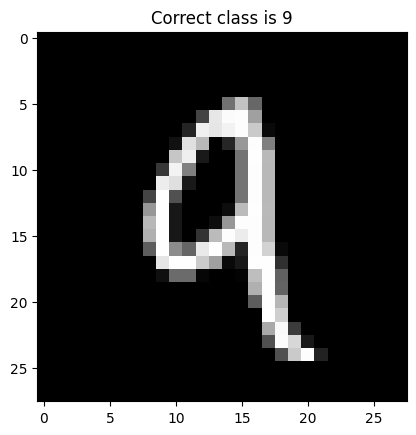

In [31]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [32]:
def plot_results(X, r, Xr, Y, l, fail=True):

    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 9, the new class will be 8
Found c = 0.000041 satisfying f(x + r) = l
Optimization succeeded with c = 0.000041 in 5 iterations
Norm Perturbation |r|: 33.627708435058594


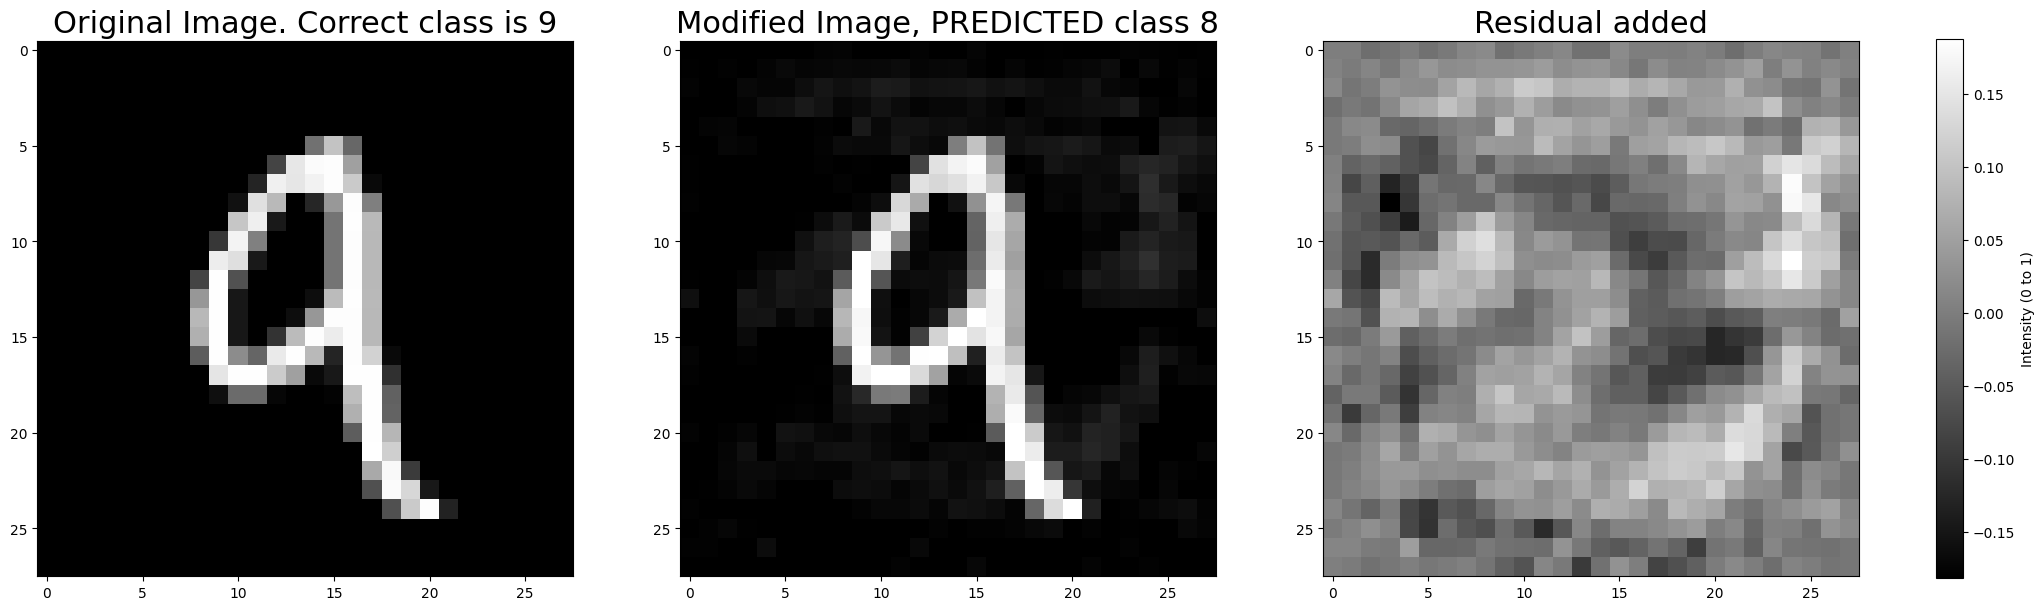

In [43]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-1 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = c * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r])

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    # If not satisfied, increase c
    c = c + 0.00001 # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?


______
------
**ANSWER** : 

- the algorithm does not always converge, for example for class 666 the algo failed to generate a disturbance, 
for index=125, which is a 9 it works. 

- impact of modifying c regularization coef; if it's too large, the noise is generated too abruptly, the new class is well predicted, but there's no visual similarity with the initial figure. 

- if the regularization coef is adapted, then we succeed in predicting the target class while keeping a visual representation close to the initial class. We also note that the algo's convergence efficiency depends on the level of similarity between the target class and the initial class. 

*We have tested multiples scenarios, here is a recap:* 

- If the regularization coefficient is too high (c of the order of e10-3) => reclassification works, but the aesthetic aspect of the image is lost. 
- If the regularization coef is lower (c of the order of e10-5, for example) but the target image representation is too far from the initial image, then we fail: a higher coef c is needed to succeed, implying a more brutal modification of the initial image to reclassify it properly. (from e10-5 to e10-3).
- If the regularization coefficient is low enough and the target image representation is close to the initial image, then the adversarial attack is successful.

To conclude, if the regularization coefficient is too high, the image will be reclassified to the target label, but the visual aspect of the image will not be preserved, and the image will no longer be of interest as it no longer represents anything. The average distortion is about 100/3


-------
-------

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

In [44]:
# MODELS TO BE TESTED : 
hidden_sizes =[5,50]
model_5_50 = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model_5_50.parameters(), lr=learning_rate, weight_decay=weight_decay)
training(model_5_50, train_loader, optimizer, num_epochs, loss_model,verbose=False)

hidden_sizes =[3,150]
model_3_150 = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
optimizer = optim.Adam(model_3_150.parameters(), lr=learning_rate, weight_decay=weight_decay)
training(model_3_150, train_loader, optimizer, num_epochs, loss_model, verbose=False)


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [57]:
def product_adversarial_instance(model, model2, verbose = False) : 

    dict_result = {}

    for i in range(10): 
        sucess = False
        r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
        label= testY - i # manually chosen target class label different from true one
        l = torch.tensor([label]).to(device)  
        l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
        print(f"The true class is {testY}, the new class will be {l[0]}")


        # Define the loss function
        def objective(c, r, x, l):
            term1 = c * torch.norm(r)
            term2 = loss_model(model(x+r), l)
            return term1 + term2


        # Line search to find the minimum c > 0
        c = initial_c
        iter=0
        while (c <= max_c) and (iter <= max_iter_search):    
            # Define the optimizer (Box-Constrained L-BFGS)
            optimizerLBFGS = optim.LBFGS([r])

            def closure():
                optimizerLBFGS.zero_grad()
                loss = objective(c, r, testI, l)
                loss.backward()
                return loss

            # Perform optimization
            optimizerLBFGS.step(closure)


            # Evaluate the condition f(x + r) = l
            with torch.no_grad():
                x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
                pred = model(x_r)
                predicted_label = torch.argmax(pred, dim=1)

            # Check if the condition f(x + r) = l is satisfied
            if predicted_label == l:
                print(f"Found c = {c:.6f} satisfying f(x + r) = l")
                iter=iter+1
                break
            else:
                iter=iter+1

            # If not satisfied, increase c
            c = c + 0.00001 # Adjust step size for line search
            if verbose : 
                if (iter) % 20 == 0:
                    print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

        if (c > max_c) or (iter > max_iter_search):
            print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
            #print(f"Perturbation r: {r}")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

            plot_results(testI, r, x_r, testY, l, fail=True)

        else:
            print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
            #print(f"Perturbation r: {r}")
            print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
            succes = True
            plot_results(testI, r, x_r, testY, l, fail=False)
        
        dict_result[i] = {'c' : c,
                          'norm_r' : torch.norm(r, p=1), 
                          'succes' : succes}

        print("\nTesting adversarial example on other model...")
        model2.to(device)
        model2.eval()

        with torch.no_grad():
            pred = model2(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        if predicted_label != l:
            print ("#######################################################")
            print(f"Adversarial example misclassified by other model as class {predicted_label.item()} instead of {l}.")
            print ("#######################################################")

        else:
            print(f"Adversarial example correctly classified by the other model")


The true class is 9, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 7.83125114440918


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


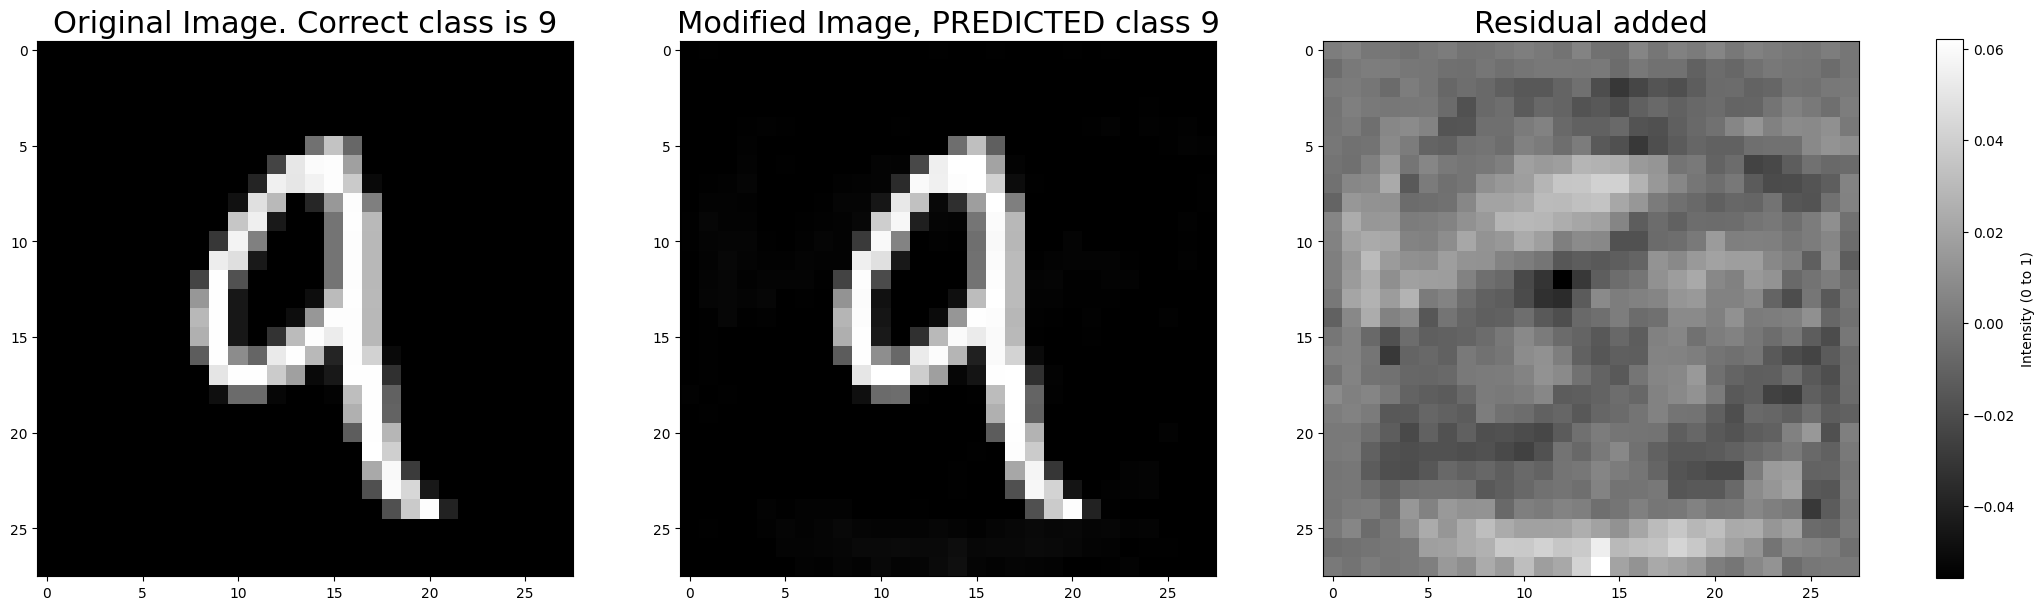


Testing adversarial example on other model...
Adversarial example correctly classified by the other model
The true class is 9, the new class will be 8
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 3644588294144.0


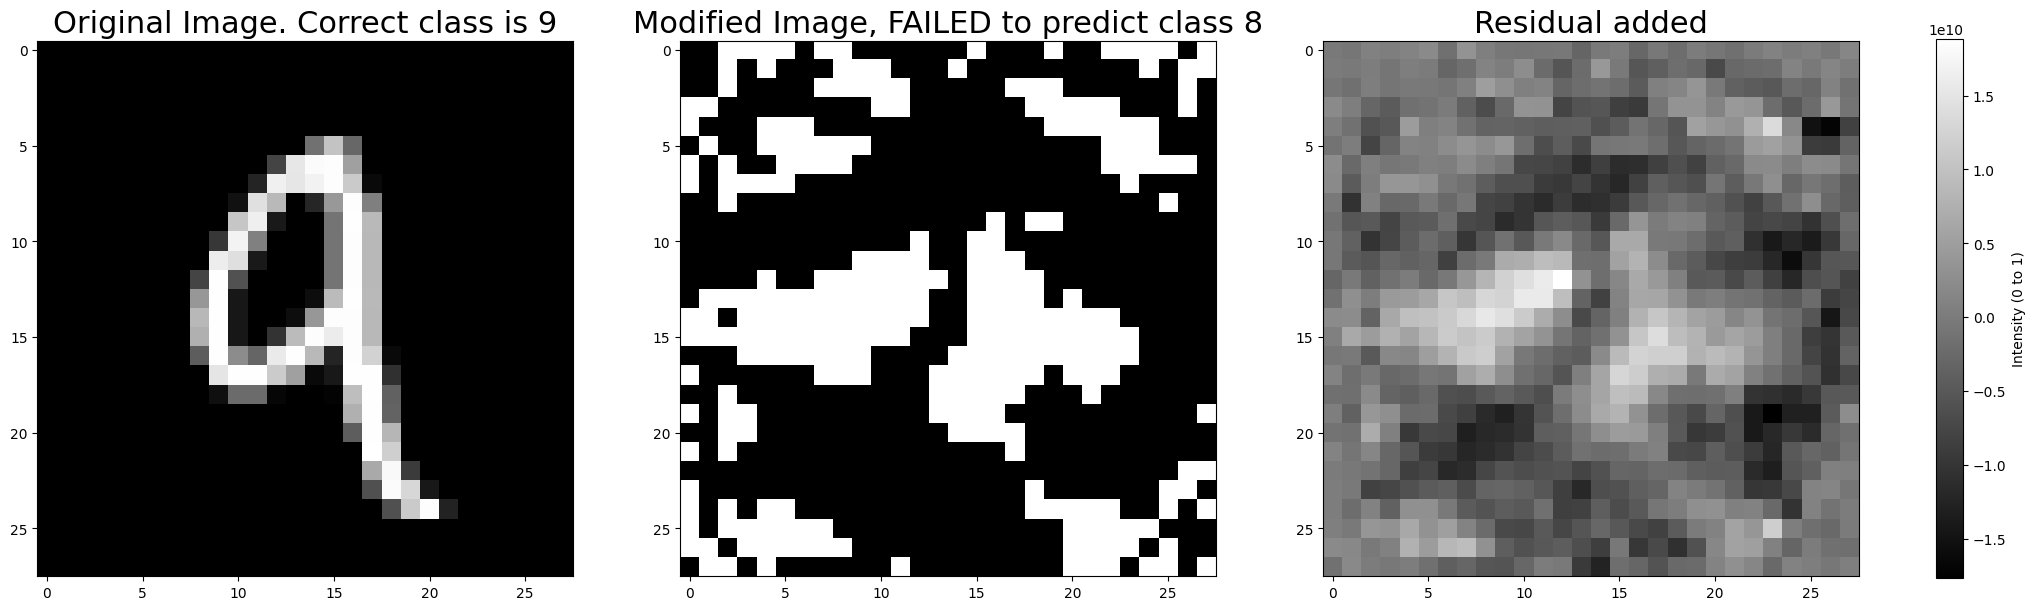


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 4 instead of tensor([8], device='cuda:0').
#######################################################
The true class is 9, the new class will be 7
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 6.976442443954064e+20


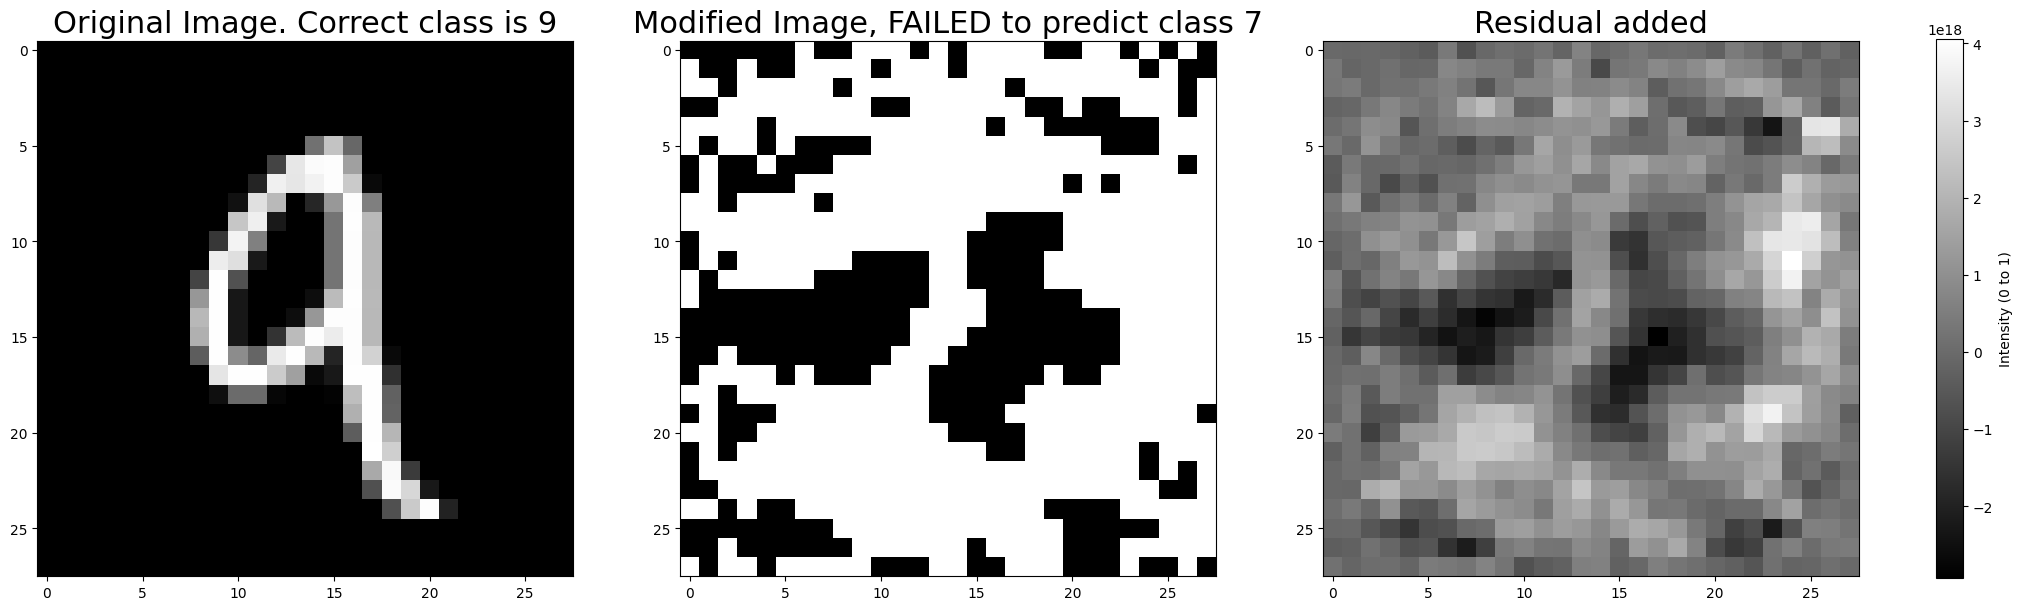


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 5 instead of tensor([7], device='cuda:0').
#######################################################
The true class is 9, the new class will be 6
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 4316410880.0


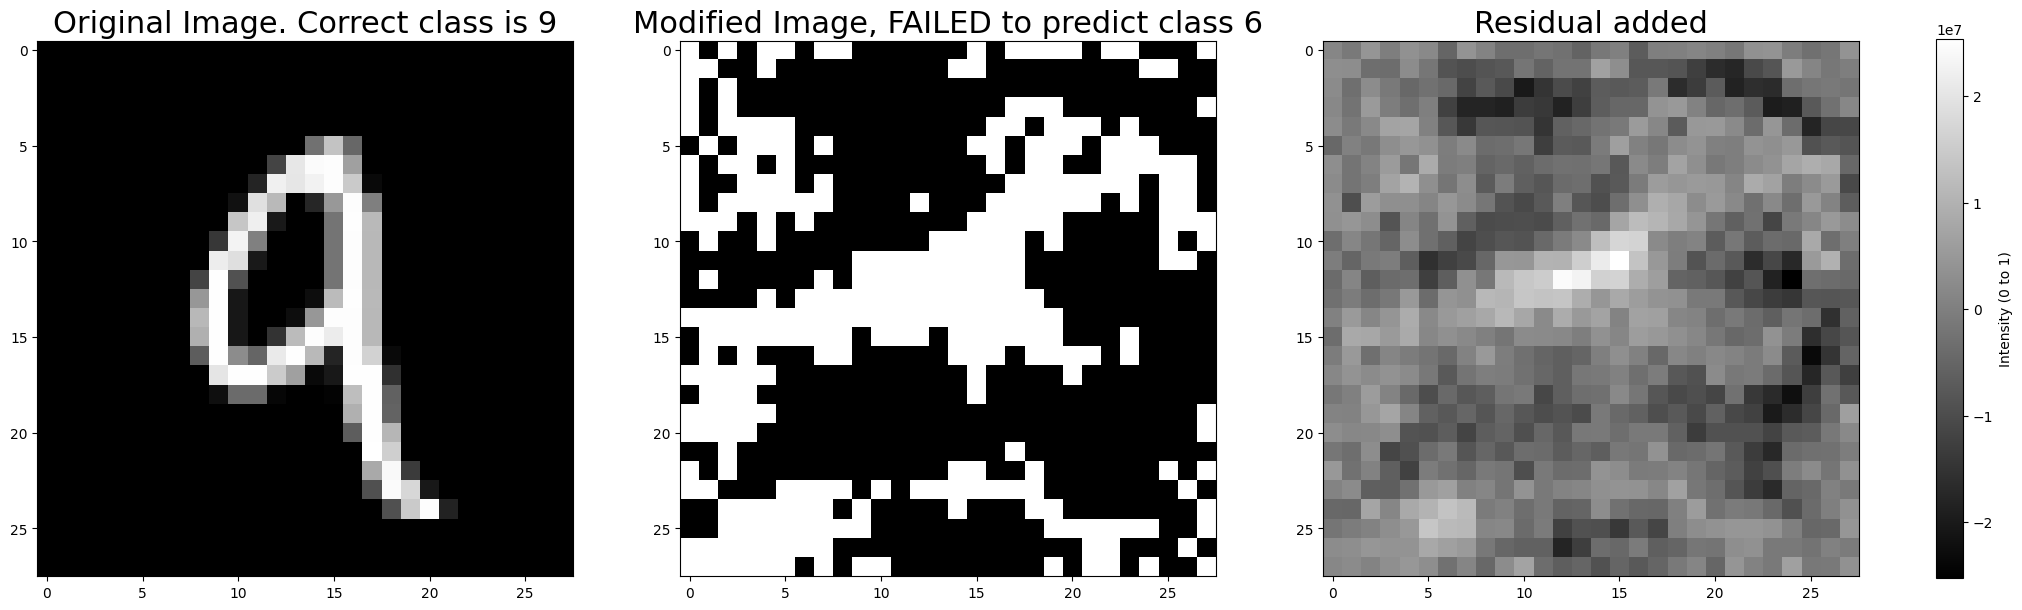


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 3 instead of tensor([6], device='cuda:0').
#######################################################
The true class is 9, the new class will be 5
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 8.461647033691406


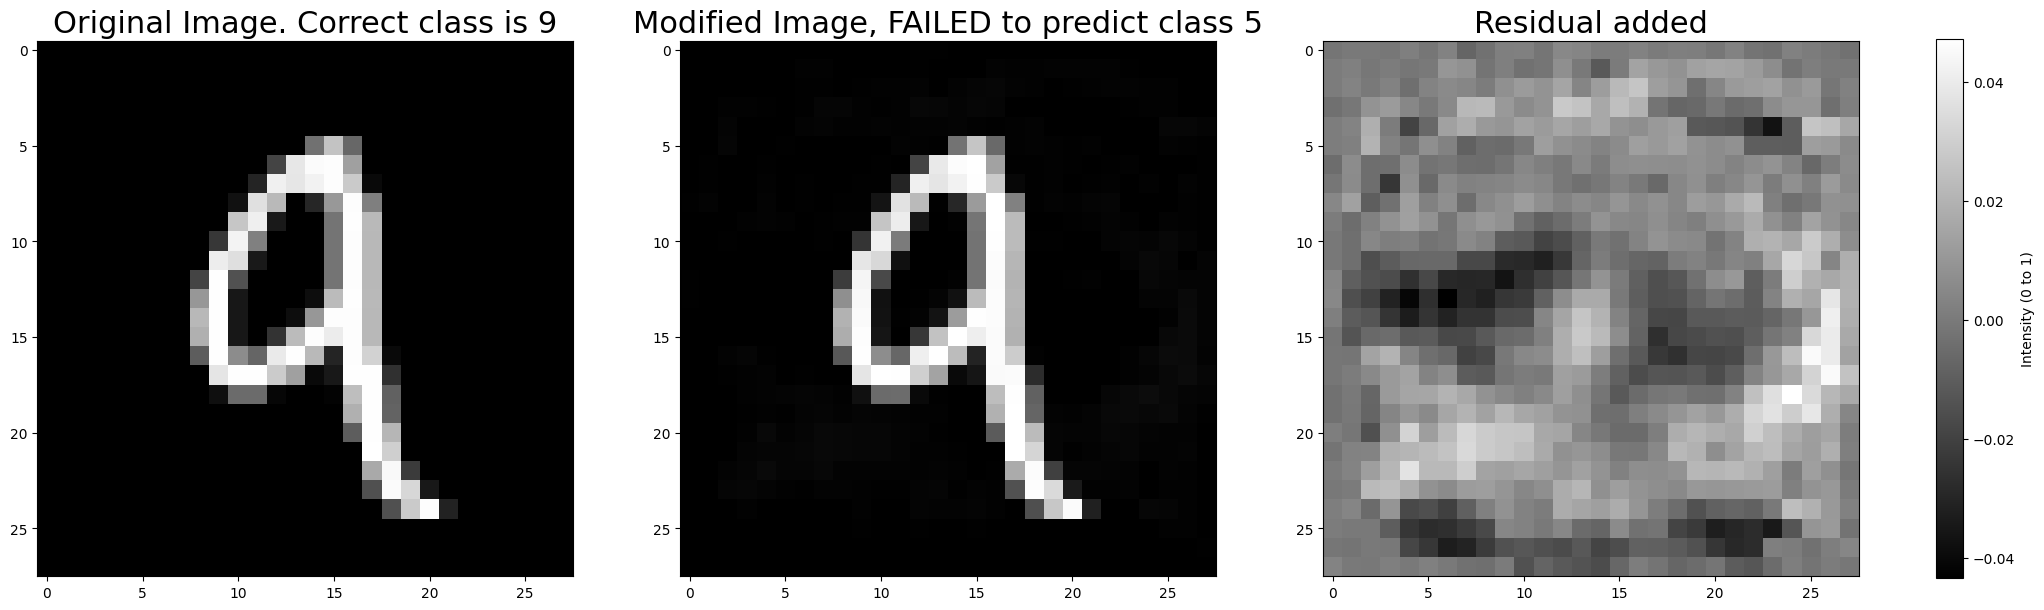


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 9 instead of tensor([5], device='cuda:0').
#######################################################
The true class is 9, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 15.752314567565918


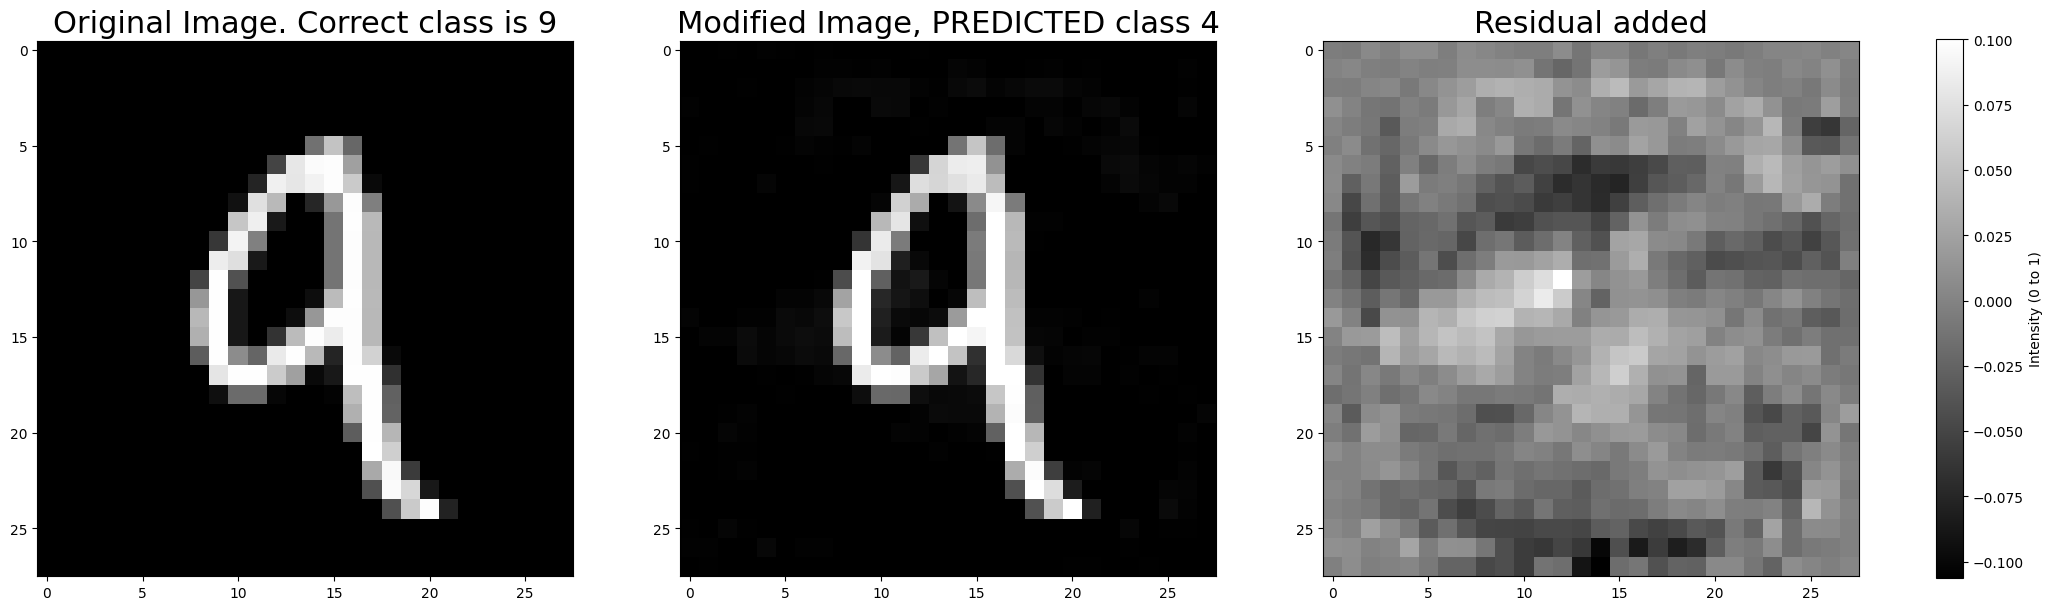


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 9 instead of tensor([4], device='cuda:0').
#######################################################
The true class is 9, the new class will be 3
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 2.0119308917720916e+23


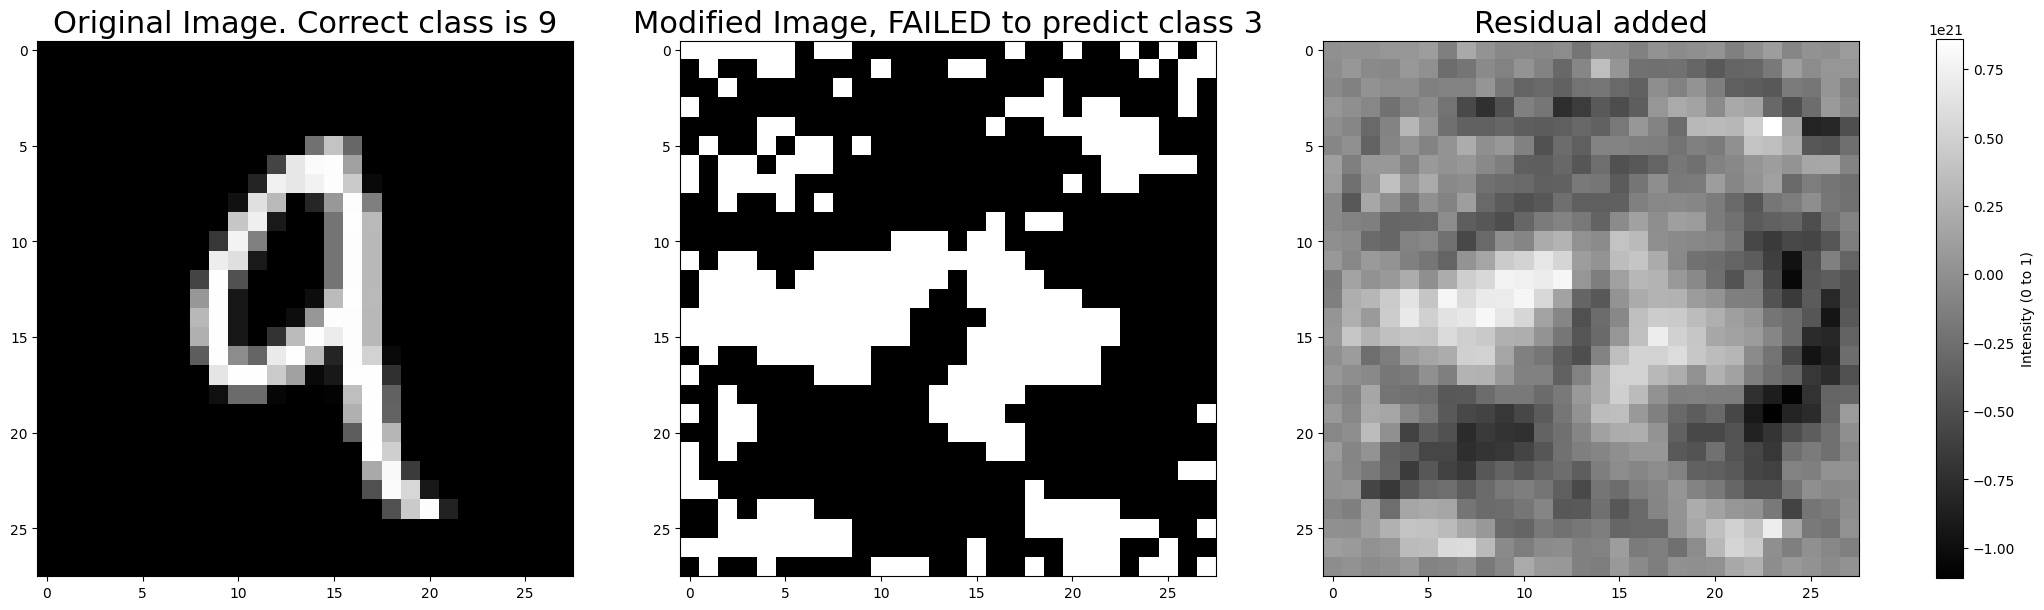


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 9 instead of tensor([3], device='cuda:0').
#######################################################
The true class is 9, the new class will be 2
Found c = 0.000721 satisfying f(x + r) = l
Optimization succeeded with c = 0.000721 in 73 iterations
Norm Perturbation |r|: 6.689199904233118e+21


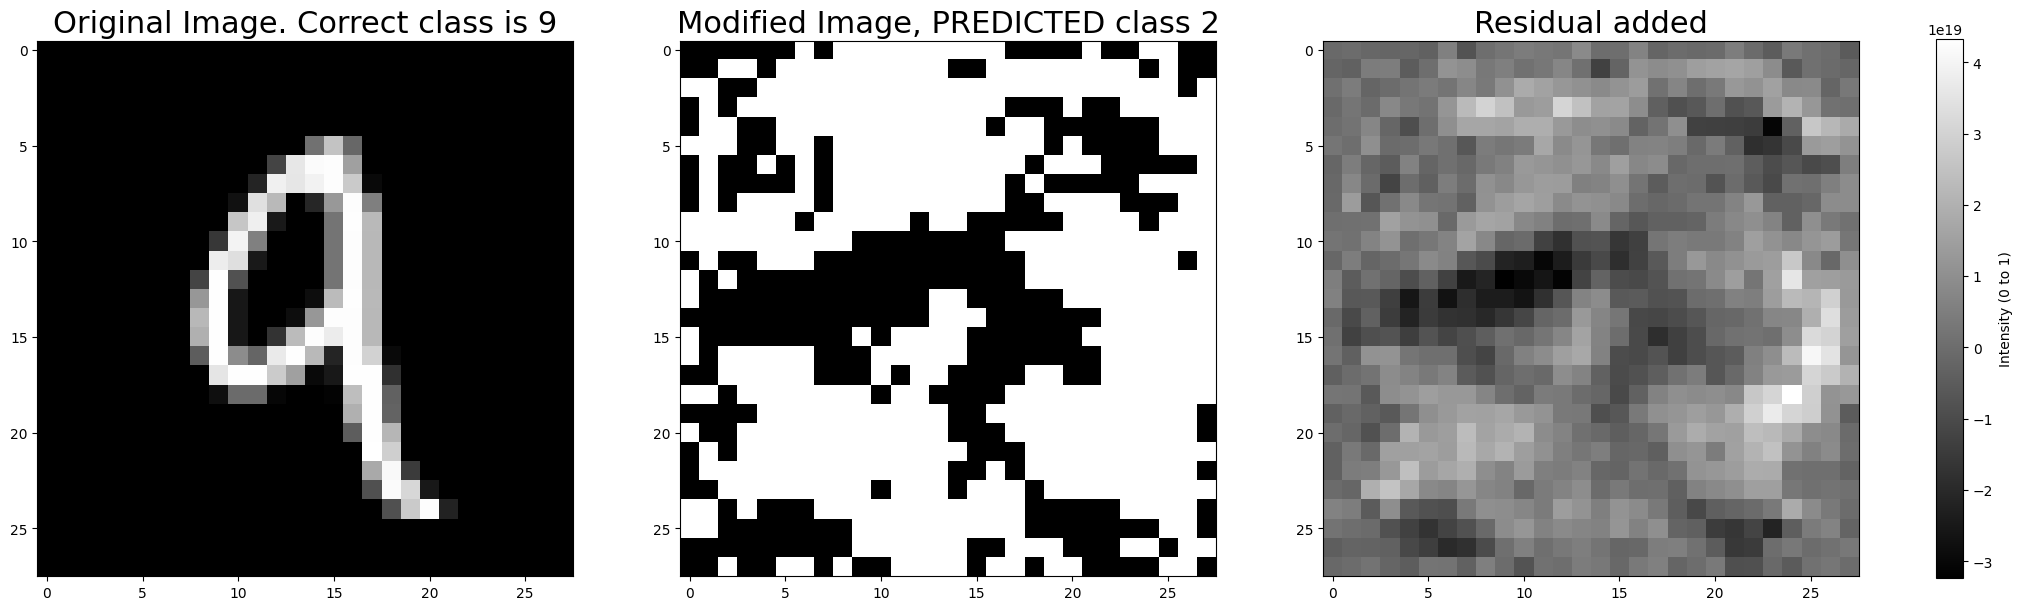


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 5 instead of tensor([2], device='cuda:0').
#######################################################
The true class is 9, the new class will be 1
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 1.640916320997553e+19


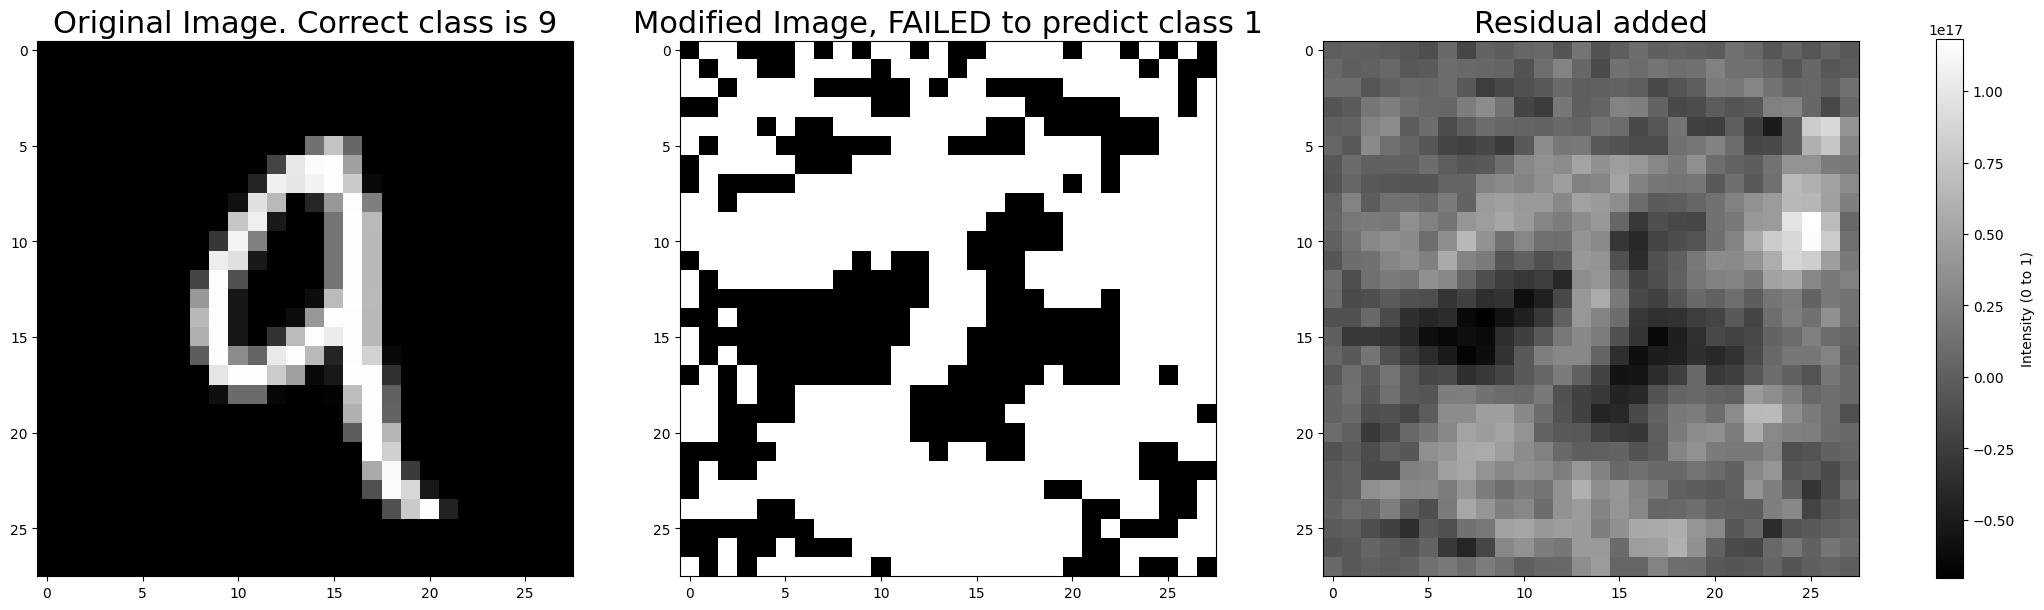


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 3 instead of tensor([1], device='cuda:0').
#######################################################
The true class is 9, the new class will be 0
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 1.0641942869081699e+23


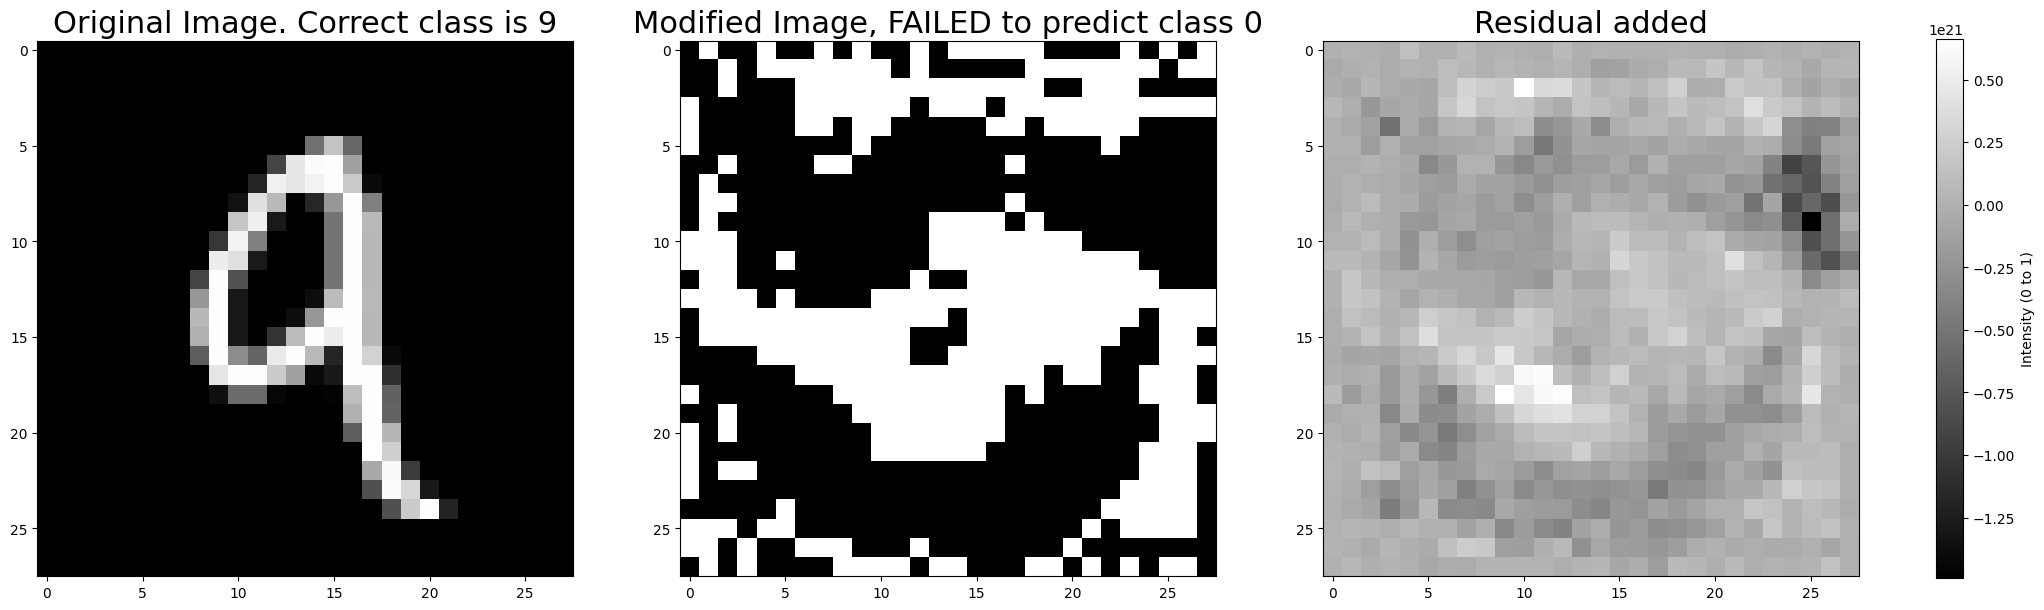


Testing adversarial example on other model...
#######################################################
Adversarial example misclassified by other model as class 6 instead of tensor([0], device='cuda:0').
#######################################################


In [58]:
product_adversarial_instance(model_3_150, model_5_50)

## **Comments :**

We see that the result of the adverserial attack depenn on the model used. Sometimes the adverarial attack work for one modele but not for the other one. It makes sense because the optimzation depend on the achitecture of the models so the perturbation cant work from a model to another one. 

For instance the adversial attack work for the model [3,150] for target 4, but the other model classify it 9, according to what we see on the image. (cf above plots)

-------
-------

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

### r and c optimized

If we optimize jointly both parameters, we have a negative c. We need to change the loss function by taking the absolute value of c

The true class is 9, the new class will be 4
Iter 20/3000, Value of c: -0.004459
Found c = 0.002812 satisfying f(x + r) = l
Optimization succeeded with c = 0.002812 in 28 iterations
Norm Perturbation |r|: 20.00248908996582


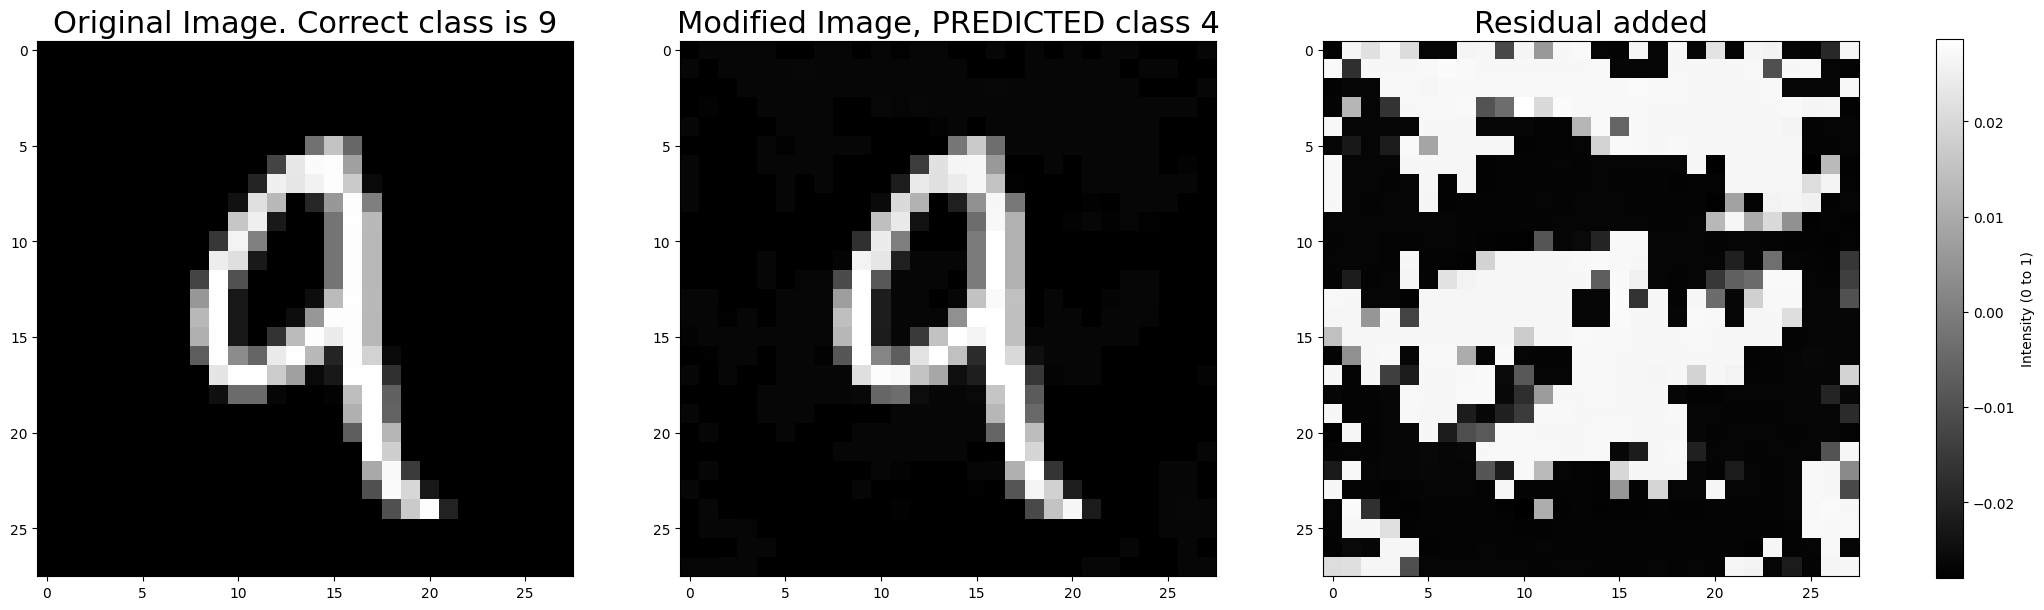

In [61]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-5 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = torch.absolute(c) * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


# Line search to find the minimum c > 0
c = initial_c
c = torch.tensor([c]).to(device)  
c = torch.nn.Parameter(c)
iter=0

# Define the optimizer (Adam Optimizer)
optimizerAdam = optim.Adam([r, c])

while (c <= max_c) and (iter <= max_iter_search):    

    # Perform optimization
    loss = objective(c, r, testI, l) #The loss is our objective function
    loss.backward()
    optimizerAdam.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c.item():.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c.item():.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c.item():.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

### r optimized alone

The true class is 9, the new class will be 7
Iter 20/3000, Value of c: 0.005000
Iter 40/3000, Value of c: 0.005000
Iter 60/3000, Value of c: 0.005000
Iter 80/3000, Value of c: 0.005000
Iter 100/3000, Value of c: 0.005000
Iter 120/3000, Value of c: 0.005000
Iter 140/3000, Value of c: 0.005000
Iter 160/3000, Value of c: 0.005000
Iter 180/3000, Value of c: 0.005000
Found c = 0.005000 satisfying f(x + r) = l
Optimization succeeded with c = 0.005000 in 187 iterations
Norm Perturbation |r|: 41.951995849609375


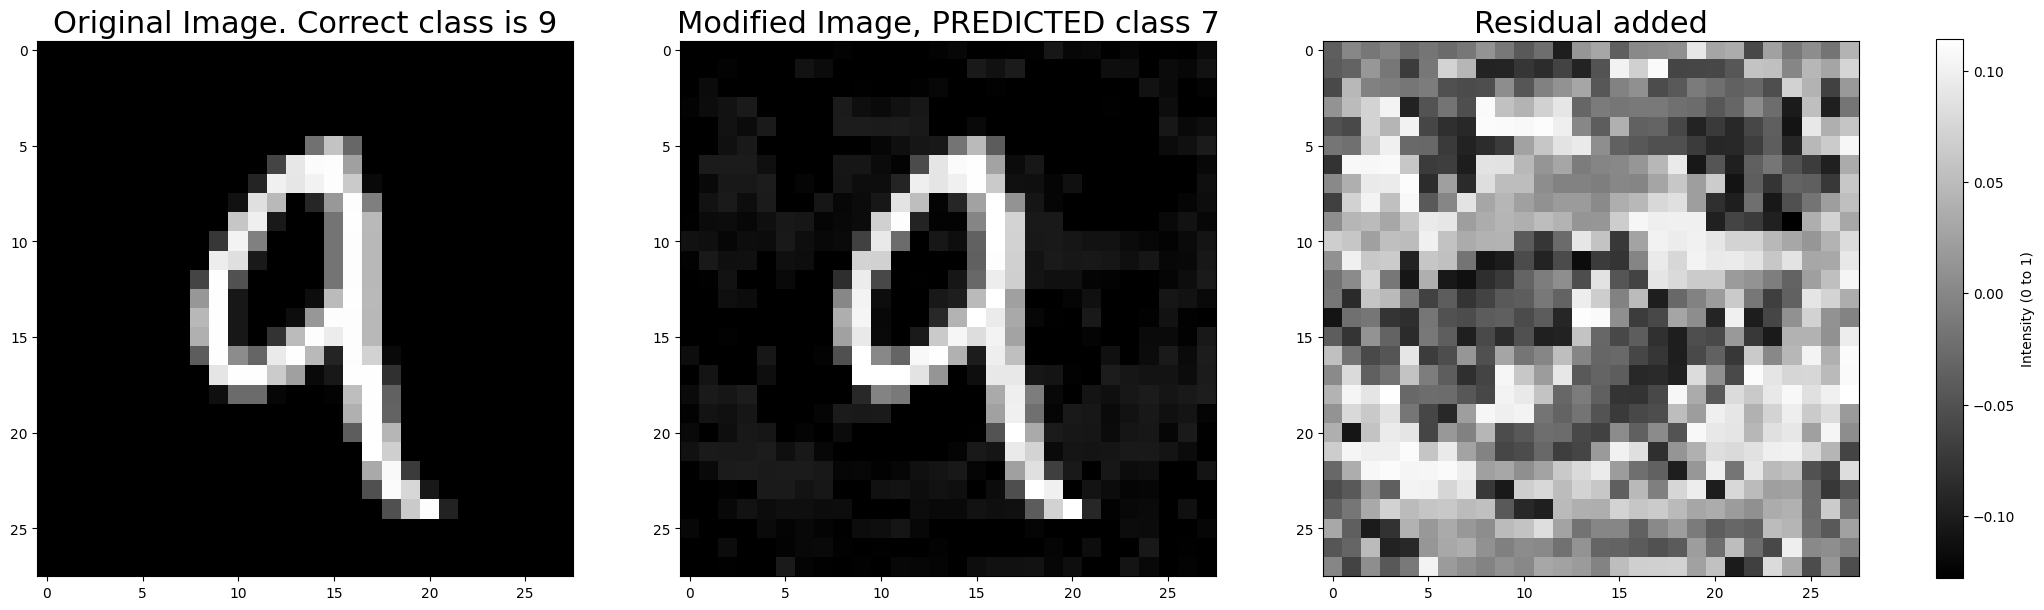

In [64]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label= testY-2 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    term1 = c * torch.norm(r)
    term2 = loss_model(model(x+r), l)
    return term1 + term2


# Line search to find the minimum c > 0
c = 0.005
iter=0

# Define the optimizer (Adam Optimizer)
optimizerAdam = optim.Adam([r])

while (c <= max_c) and (iter <= max_iter_search):    

    # Perform optimization
    loss = objective(c, r, testI, l) #The loss is our objective function
    loss.backward()
    optimizerAdam.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [65]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

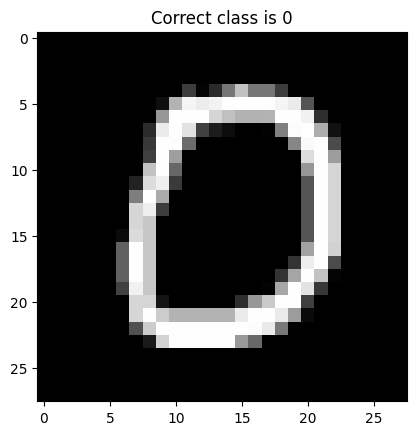

In [66]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

In [ ]:
eps = XXXXXXX # perturbation size

# Forward pass of X through the model
pred_original = model(X)  
original_class=XXXXXXXX

# Compute loss
cost = XXXXXXXX

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = XXXXXXX
Xr = XXXXXXX

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class=XXXXXXXXXX    

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)   
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

In [ ]:
def fgsm_attack(X, Y, model, loss_model, eps):

    XXXXXXXXXX 

    return Xr, original_class, perturbed_class, r

# Accuracy counter
adv_examples = []
succes=0
eps = XXXXXXX # perturbation size

# Loop over all examples in test set
for X_batch, Y_batch in test_loader:  # Iterate through batches
    for X, Y in zip(X_batch, Y_batch):
        
        XXXXXXXXXX

# Calculate final accuracy for this epsilon
Adv_acc = XXXXXXX
print(f"Using epsilon: {eps} we succesfully create {Adv_acc} % adversariale examples")   

# Plot one example
index=0
plot_results(XXXXXXX)